# Chapter 18 chapter exercises

In [1]:
# import libraries 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# define global figure properties 
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # display figures in vector format
plt.rcParams.update({'font.size':14,             # font size
                     'axes.titlelocation':'left',# title location
                     'axes.spines.right':False,  # remove axis bounding box
                     'axes.spines.top':False,    # remove axis bounding box
                     })
     

### Exe 1

In [3]:
N = 30

# create new data
data = np.random.randn(N)

# trim
idx = np.argsort(data)
dataTrim = data[idx[2:]]

# ttests
ttestO = stats.ttest_1samp(data,0)
ttestT = stats.ttest_1samp(dataTrim,0)

# results
print(f'Full: t({ttestO.df}) = {ttestO.statistic:.3f}, p = {ttestO.pvalue:.3f}')
print(f'Trim: t({ttestT.df}) = {ttestT.statistic:.3f}, p = {ttestT.pvalue:.3f}')

Full: t(29) = -1.131, p = 0.267
Trim: t(27) = -0.444, p = 0.661


In [5]:
N = 30
numreps = 1000


pLessThan05 = np.zeros((numreps,3))
tValues = np.zeros((numreps,3))

for expi in range(numreps):

  # create new data
  data = np.random.randn(N)

  # trim
  idx = np.argsort(data)
  dataTrimL = data[idx[2:]]
  dataTrimB = data[idx[1:-1]]

  # ttests
  ttestO = stats.ttest_1samp(data,0)      # O = original
  ttestL = stats.ttest_1samp(dataTrimL,0) # L = left side trimmed
  ttestB = stats.ttest_1samp(dataTrimB,0) # B = both sides trimmed

  # store "significances"
  pLessThan05[expi,0] = ttestO.pvalue<.05
  pLessThan05[expi,1] = ttestL.pvalue<.05
  pLessThan05[expi,2] = ttestB.pvalue<.05

  # store t-values
  tValues[expi,0] = ttestO.statistic
  tValues[expi,1] = ttestL.statistic
  tValues[expi,2] = ttestB.statistic


# results
print(f' Without data trimming: {np.sum(pLessThan05[:,0],dtype=int):>3}/{expi+1} with p<.05 ({100*np.mean(pLessThan05[:,0]):>5.2f}%)')
print(f' With symmetric trimming: {np.sum(pLessThan05[:,2],dtype=int):>3}/{expi+1} with p<.05 ({100*np.mean(pLessThan05[:,2]):>5.2f}%)')
print(f'With asymmetric trimming: {np.sum(pLessThan05[:,1],dtype=int):>3}/{expi+1} with p<.05 ({100*np.mean(pLessThan05[:,1]):>5.2f}%)')
     

 Without data trimming:  42/1000 with p<.05 ( 4.20%)
 With symmetric trimming:  72/1000 with p<.05 ( 7.20%)
With asymmetric trimming: 140/1000 with p<.05 (14.00%)


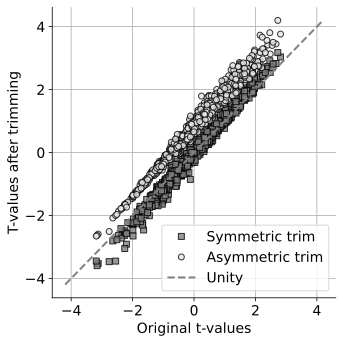

In [6]:
# visualize change in t-values
plt.figure(figsize=(5,5))

# plot t-values
plt.plot(tValues[:,0],tValues[:,2],'ks',markersize=6,alpha=.8,markerfacecolor=(.5,.5,.5),label='Symmetric trim')
plt.plot(tValues[:,0],tValues[:,1],'ko',markersize=6,alpha=.8,markerfacecolor=(.9,.9,.9),label='Asymmetric trim')

# plot the unity line
extT = np.max(np.abs(tValues))
plt.plot([-extT,extT],[-extT,extT],linewidth=2,linestyle='--',color='gray',label='Unity')

plt.xticks(range(-4,5,2))
plt.yticks(range(-4,5,2))
plt.xlabel('Original t-values')
plt.ylabel('T-values after trimming')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Exe 2

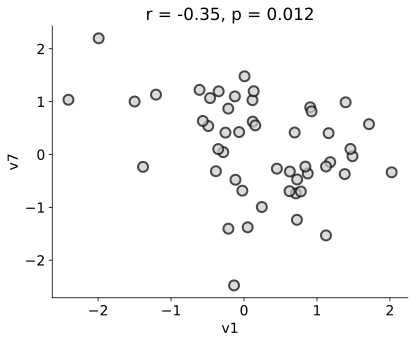

In [7]:
# generate data in a DataFrame
df = pd.DataFrame(np.random.randn(50,10), columns=[f'v{i}' for i in range(10)])

# Pearson correlation matrix
R = df.corr()

# Mask the diagonal to ignore r=1
np.fill_diagonal(R.values,0)

# find indices of max pair
xi,yi = np.where(R.abs()==np.max(R.abs().values))[0]

# get p-value
pval = stats.pearsonr(df.iloc[:,xi],df.iloc[:,yi])[1]


# Scatter plot of the variables with the highest correlation
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x=df.columns[xi], y=df.columns[yi],
                s=100,edgecolor='k',facecolor=(.8,.8,.8),linewidth=2,alpha=.7)
plt.title(f'r = {R.iloc[xi,yi]:.2f}, p = {pval:.3f}',loc='center')

plt.tight_layout()
plt.show()

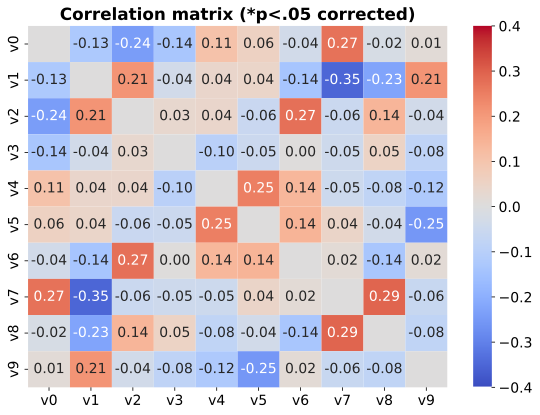

In [9]:
# convert R to dataframes for seaborn
R_df = pd.DataFrame(R,columns=df.columns,index=df.columns)

# Bonferroni correction [ formula is (M*(M-1))/2 ]
num_comparisons = (df.shape[1]*(df.shape[1]-1)) / 2
bonferroni_thresh = .05 / num_comparisons


# Create a matrix of annotations
annot_array = R_df.astype(str).values

# loop through all elements of the matrix and create a string to display
for i in range(R_df.shape[0]):
  for j in range(R_df.shape[1]):

    # get the p-value and determine significance
    pval = stats.pearsonr(df.iloc[:,i],df.iloc[:,j])[1]
    significant = pval < bonferroni_thresh

    # the string depends on the significance
    if not significant:
      # if non-significant, just the correlation coefficient
      annot_array[i,j] = f'{R_df.iloc[i, j]:.2f}'
    else:
      # if significant, add an asterisk to the coefficient
      annot_array[i,j] = f'{R_df.iloc[i, j]:.2f}*'

    # don't need to report the diagonals
    if i==j:
      annot_array[i,j] = ''


# plot
plt.figure(figsize=(8,6))
sns.heatmap(R_df,annot=annot_array,fmt='s',cmap='coolwarm',vmin=-.4,vmax=.4,
            xticklabels=R_df.columns,yticklabels=R_df.columns)
plt.title('Correlation matrix (*p<.05 corrected)',loc='center',weight='bold')

# display figure
plt.tight_layout()
plt.show()